In [ ]:
!pip install keras-tuner

In [1]:
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Carregar dados (CIFAR10)

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [6]:
print('Shape de treino')
print(x_train.shape)
print('Shape de teste')
print(x_test.shape)
print('Shape labels treino')
print(y_train.shape)
print('Shape labels teste')
print(y_test.shape)

Shape de treino
(50000, 32, 32, 3)
Shape de teste
(10000, 32, 32, 3)
Shape labels treino
(50000, 10)
Shape labels teste
(10000, 10)


# Analisar e visualizar dados

**************************************************
Training set shape: (50000, 32, 32, 3) and testing set shape: (10000, 32, 32, 3)
Training labels set shape: (50000, 1) and testing labels set shape: (10000, 1)
There are 50000 elems in the training set and 10000 in the test set
**************************************************


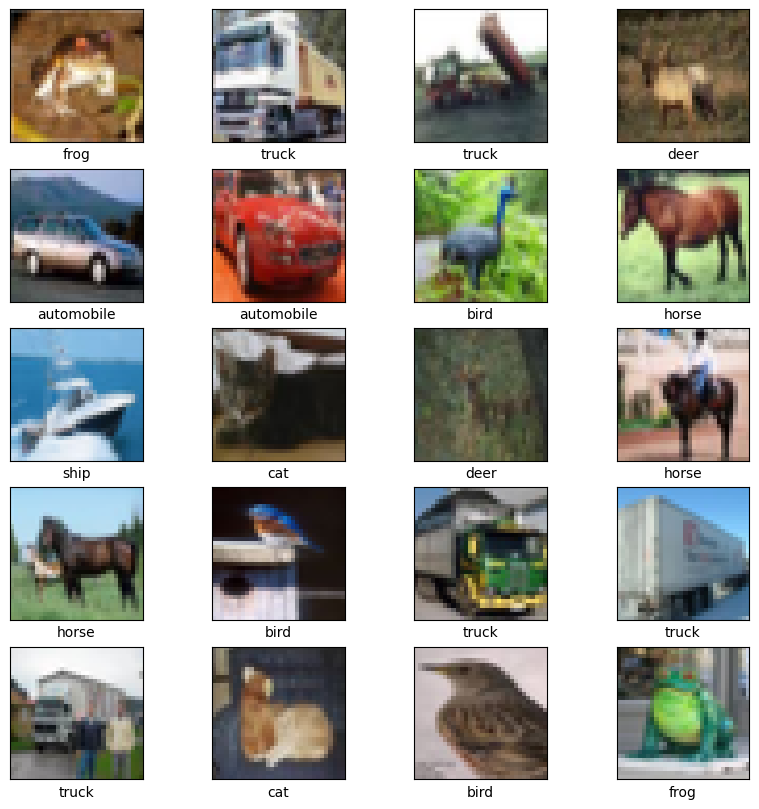

In [49]:
print(50*'*')
print("Training set shape:", x_train.shape, "and testing set shape:", x_test.shape)
print("Training labels set shape:", y_train.shape, "and testing labels set shape:", y_test.shape)
print("There are", len(x_train), "elems in the training set and", len(x_test), "in the test set")
print(50*'*')

plt.figure(figsize=(10,10))
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(tf.squeeze(x_train[i]))
  plt.xlabel(classes[y_train[i][0]])
plt.show()

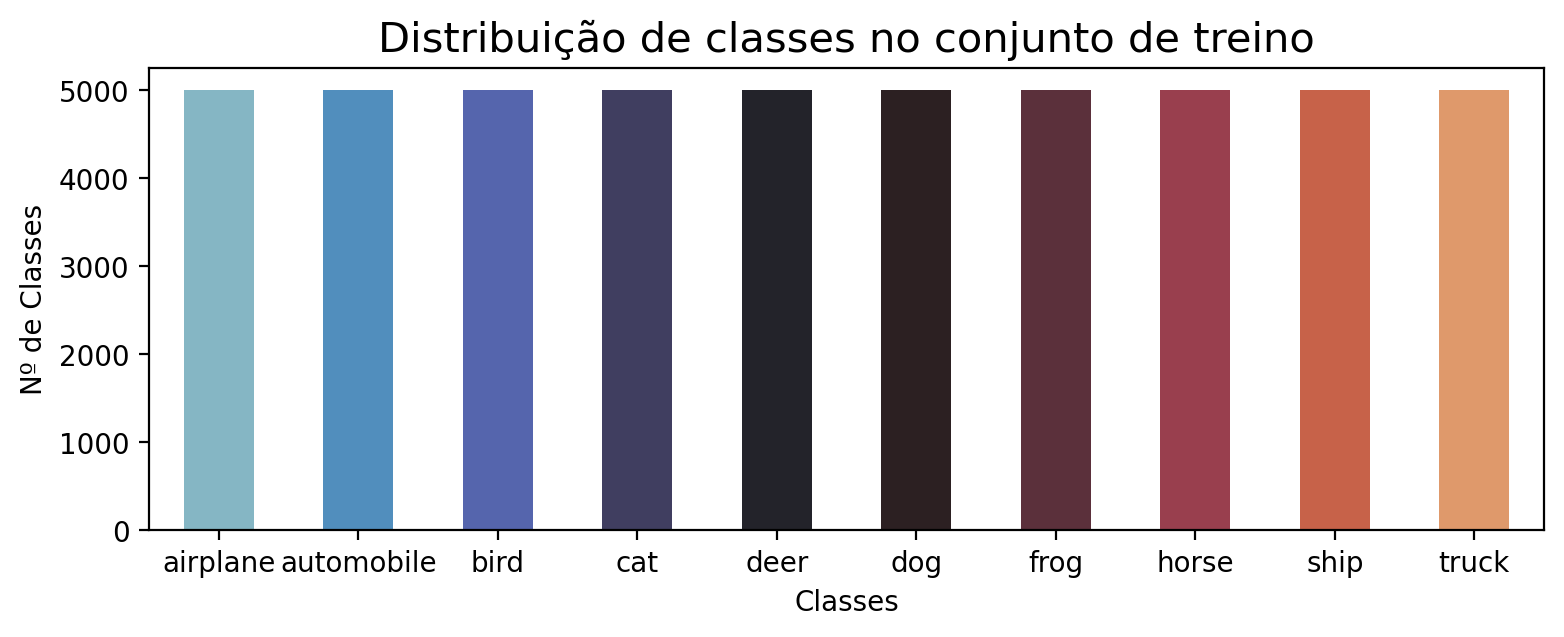

In [43]:
label, count = np.unique(y_train, return_counts=True)
uni = pd.DataFrame({'Classes': classes, 'Nº de Classes': count})

plt.figure(figsize=(9, 3), dpi=200)
ax = sns.barplot(data=uni, x='Classes', y='Nº de Classes', hue='Classes', palette='icefire', width=0.5, legend=False)
ax.set_title('Distribuição de classes no conjunto de treino', fontsize=15)

plt.show()

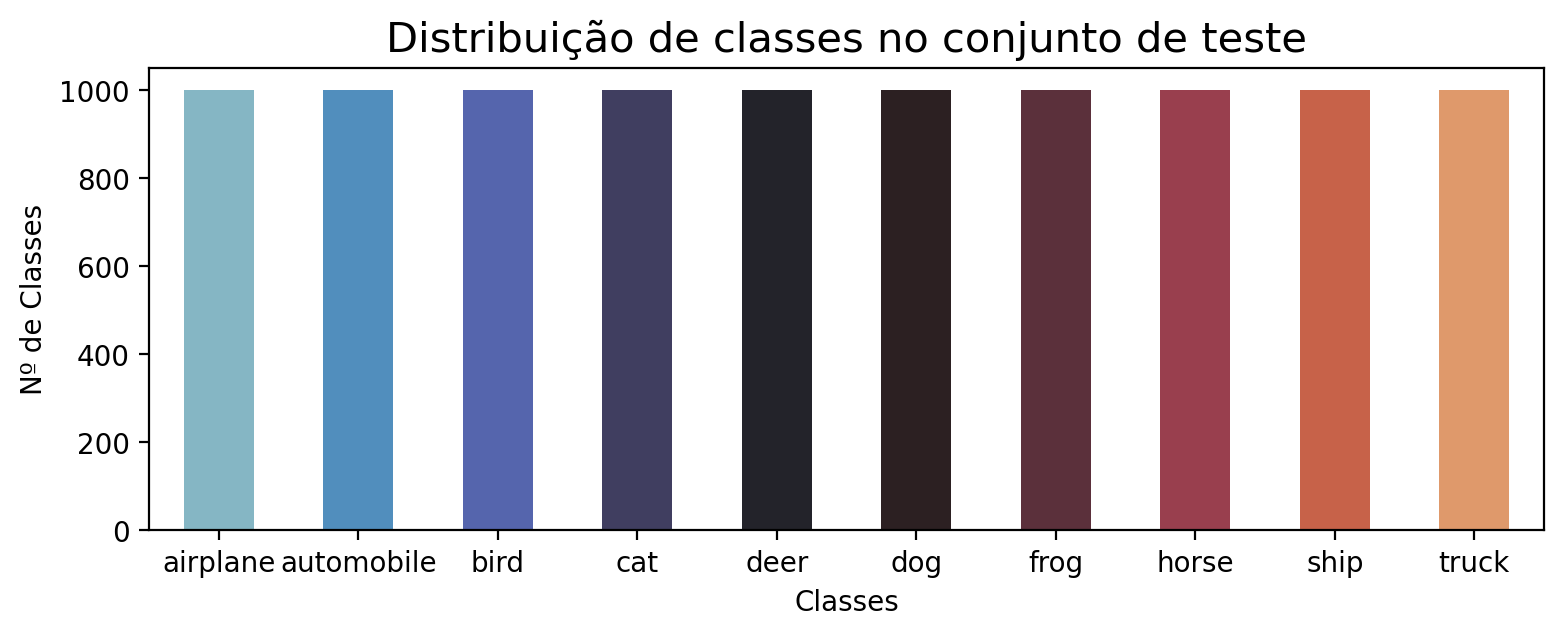

In [44]:
label, count = np.unique(y_test, return_counts=True)
uni = pd.DataFrame({'Classes': classes, 'Nº de Classes': count})

plt.figure(figsize=(9, 3), dpi=200)
ax = sns.barplot(data=uni, x='Classes', y='Nº de Classes', hue='Classes', palette='icefire', width=0.5, legend=False)
ax.set_title('Distribuição de classes no conjunto de teste', fontsize=15)

plt.show()

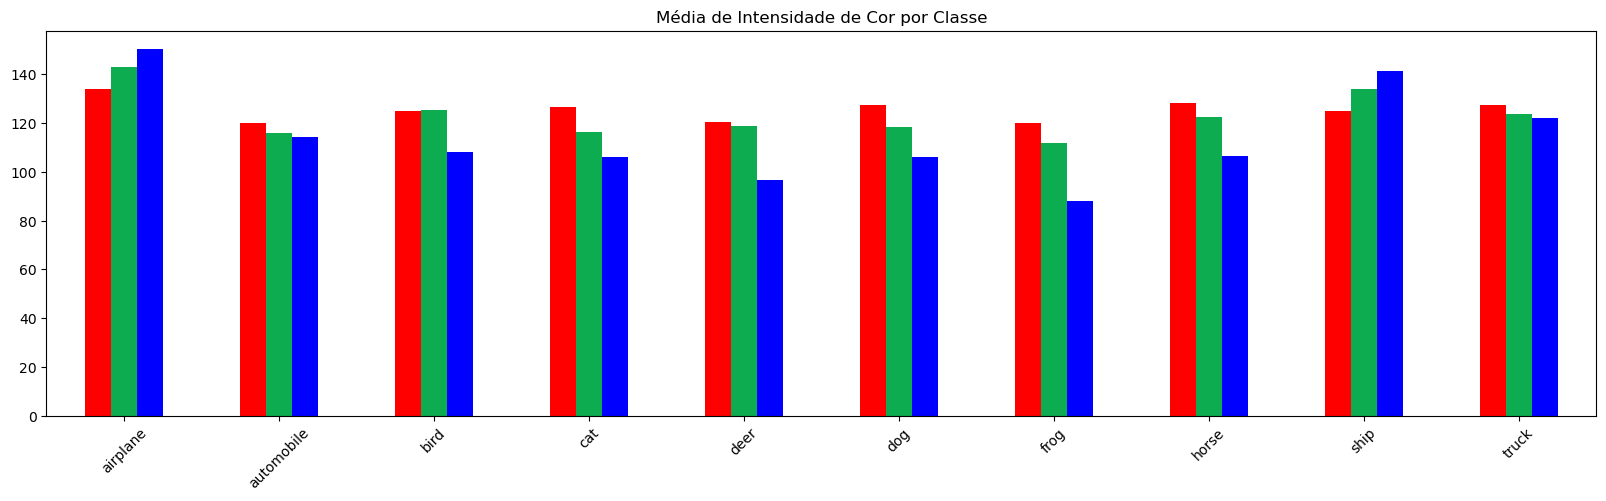

In [ ]:
means = {c: np.mean(x_train[y_train.flatten() == i], axis=(0, 1, 2)) for i, c in enumerate(classes)}

df = pd.DataFrame(means).T
cores = ['Red', '#0DAC50', 'Blue']

df.plot(kind = 'bar', figsize = (20, 5), color = cores)
plt.title("Média de Intensidade de Cor por Classe")
plt.xticks(rotation = 45)
plt.legend().remove()
plt.show()

Example of insights: 
Planes might be generally blueish (sky background), trucks or fire engines could be reddish, frogs might have more green.
If you saw the class "Frog" has a much higher Green mean, and "Airplane" has higher Blue mean,
you can expect that the model might first learn color features during training — before shapes or textures.

Why is this important for model training?
If one color dominates a class, the model might become lazy: it won't learn the true shape, just the color.
If you find big color differences between classes, you might want to add data augmentations like color jittering (random brightness/saturation shifts) during training to make your model more robust.
Also, you can interpret why the model makes mistakes later ("Oh, it thought the frog was a tree because both are green...").

# model.add(tf.keras.layers.RandomContrast(0.2))
# model.add(tf.keras.layers.RandomBrightness(0.2))
Pensar em adicionar esta ccolor-based augmentation

# Normalizar dados

In [5]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# CNN (com data augmentation)

In [ ]:
def build_model_CNN_da(hp):
  model = tf.keras.Sequential()
  
  model.add(tf.keras.layers.RandomFlip('horizontal', input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.RandomRotation(0.05))
  model.add(tf.keras.layers.RandomZoom(0.05))
  
  model.add(tf.keras.layers.Conv2D(filters=hp.Int('filter_1',min_value=64,max_value=256,step=64),kernel_size=hp.Choice('kernel_size_1',values=[3,5]), activation='relu', input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=hp.Choice('pool_1',values=[2,4])))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Conv2D(filters=hp.Int('filter_2',min_value=64,max_value=256,step=64),kernel_size=hp.Choice('kernel_size_2',values=[3,5]),activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=hp.Choice('pool_2',values=[2,4])))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=hp.Int('Unit_1',min_value=64,max_value=256,step=64),activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  model.summary()

  lr = 1e-4
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])
  return model

# CNN (sem data augmentation)

In [ ]:
def build_model_CNN_sda(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv1_filters', 64, 256, step=64), kernel_size=hp.Choice('kernel_size_1',values=[3,5]), activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=hp.Choice('pool_1',values=[2,4])))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=hp.Int('conv2_filters', 64, 256, step=64), kernel_size=hp.Choice('kernel_size_2',values=[3,5]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=hp.Choice('pool_2',values=[2,4])))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    lr = 1e-4
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# MLP

In [ ]:
def build_model_mlp(hp):
  model = tf.keras.Sequential()
  
  model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))

  model.add(tf.keras.layers.Dense(units=hp.Int('Unit_1',min_value=128,max_value=512,step=128),activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp.Int('Unit_2',min_value=128,max_value=512,step=128),activation='relu'))
  model.add(tf.keras.layers.Dense(units=10,activation='softmax'))

  lr = 1e-4
  optimizer_name = hp.Choice('optimizer', ['adam', 'sgd'])
  if optimizer_name == 'adam':
    optimizer = optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
  elif optimizer_name == 'sgd':
    optimizer = optimizer=tf.keras.optimizers.SGD(learning_rate=lr)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model


# Random Search

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner = kt.RandomSearch(
    #build_model_MLP
    #build_model_CNN_da
    build_model_CNN_sda,
    objective='val_accuracy',
    max_trials=10,
    #directory='/Cifar 10/cifar100_MLP_benchmarks',
    #directory='/Cifar 10/cifar100_CNN_da_benchmarks',
    #directory='/Cifar 10/cifar100_CNN_sda_benchmarks',
    #project_name='cifar10_MLP_benchmarks'
    #project_name='cifar10_CNN_da_benchmarks'
    #project_name='cifar10_CNN_sda_benchmarks'
)

batch_size = 32
tuner.search(
    x_train, y_train,
    epochs=25,
    validation_split=0.2,
    batch_size=batch_size,
    callbacks=[early_stop]
)

Trial 20 Complete [00h 01m 48s]
val_accuracy: 0.5627999901771545

Best val_accuracy So Far: 0.7738999724388123
Total elapsed time: 00h 50m 50s


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner = kt.GridSearch(
    build_model_CNN_sda,
    objective='val_accuracy',
    #max_trials=None,  
    # directory='/Cifar 10/cifar100_MLP_benchmarks',
    # directory='/Cifar 10/cifar100_CNN_da_benchmarks',
    #directory='/Cifar 10/cifar100_CNN_sda_benchmarks',
    #project_name='cifar10_MLP_benchmarks'
    #project_name='cifar10_CNN_da_benchmarks'
    #project_name='cifar10_CNN_sda_benchmarks'
)

batch_size = 32
tuner.search(
    x_train, y_train,
    epochs=25,
    validation_split=0.2,
    batch_size=batch_size,
    callbacks=[early_stop]
)

# Obter melhores hiperparametros e modelos

In [12]:
melhores_modelos = tuner.get_best_models(num_models=1)[0]
# melhores_modelos.summary()
melhores_hiperparametros = tuner.get_best_hyperparameters(num_trials=1)[0]
melhores_hiperparametros.get_config()['values']

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 240)    │       768,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 240)    │           960 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 240)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 240)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,536,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,312,122 (8.82 MB)

 Trainable params: 2,311,386 (8.82 MB)

 Non-trainable params: 736 (2.88 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


{'filter_1': 128,
 'kernel_size_1': 3,
 'pool_1': 2,
 'filter_2': 240,
 'kernel_size_2': 5,
 'pool_2': 2,
 'Unit_1': 256,
 'learning_rate': 0.0001}

# Treinar modelo tendo em conta random search

In [13]:
melhor_model = tuner.hypermodel.build(melhores_hiperparametros)
history = melhor_model.fit(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 240)    │       768,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 240)    │           960 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 240)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 240)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,536,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,312,122 (8.82 MB)

 Trainable params: 2,311,386 (8.82 MB)

 Non-trainable params: 736 (2.88 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3472 - loss: 1.9736 - val_accuracy: 0.5257 - val_loss: 1.3647
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5068 - loss: 1.3771 - val_accuracy: 0.5610 - val_loss: 1.2815
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5687 - loss: 1.2239 - val_accuracy: 0.5617 - val_loss: 1.3617
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5975 - loss: 1.1358 - val_accuracy: 0.6414 - val_loss: 1.0228
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6276 - loss: 1.0527 - val_accuracy: 0.5519 - val_loss: 1.4236
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6526 - loss: 0.9905 - val_accuracy: 0.6537 - val_loss: 1.0377
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6690 - loss: 0.9387 - val_accuracy: 0.6768 - val_loss: 0.9511
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6918 - loss: 0.8813 -

# Avaliar modelo

313/313 - 1s - 3ms/step - accuracy: 0.7451 - loss: 0.7871


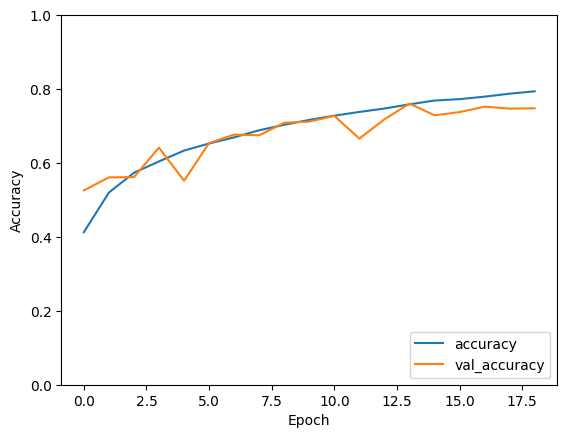

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = melhor_model.evaluate(x_test,  y_test, verbose=2)

<Axes: >

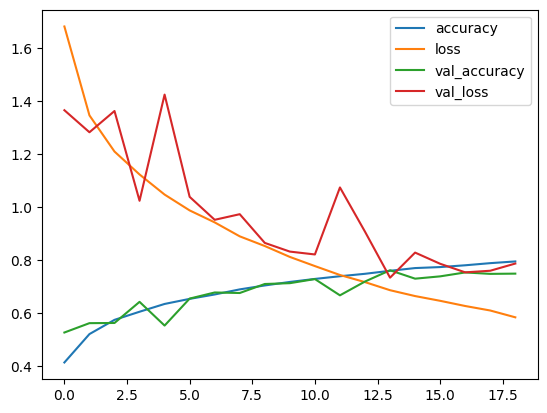

In [15]:
import pandas as pd
pd.DataFrame(history.history).plot()

# Classification Report

In [ ]:
melhor_model = tf.keras.models.load_model("cifar10_CNN_DataAugmentation.keras")
melhor_model.summary()

In [ ]:
pred = melhor_model.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
errors = y_pred - y_true != 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.86      0.78      1000
           1       0.85      0.86      0.86      1000
           2       0.80      0.52      0.63      1000
           3       0.72      0.45      0.55      1000
           4       0.69      0.74      0.72      1000
           5       0.69      0.63      0.66      1000
           6       0.81      0.83      0.82      1000
           7       0.70      0.86      0.77      1000
           8       0.85      0.79      0.82      1000
           9       0.69      0.91      0.78      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



In [32]:
print(len(x_test[0]))
print(x_test[0])

32
[[[0.61960787 0.4392157  0.19215687]
  [0.62352943 0.43529412 0.18431373]
  [0.64705884 0.45490196 0.2       ]
  ...
  [0.5372549  0.37254903 0.14117648]
  [0.49411765 0.35686275 0.14117648]
  [0.45490196 0.33333334 0.12941177]]

 [[0.59607846 0.4392157  0.2       ]
  [0.5921569  0.43137255 0.15686275]
  [0.62352943 0.44705883 0.1764706 ]
  ...
  [0.53333336 0.37254903 0.12156863]
  [0.49019608 0.35686275 0.1254902 ]
  [0.46666667 0.34509805 0.13333334]]

 [[0.5921569  0.43137255 0.18431373]
  [0.5921569  0.42745098 0.12941177]
  [0.61960787 0.43529412 0.14117648]
  ...
  [0.54509807 0.38431373 0.13333334]
  [0.50980395 0.37254903 0.13333334]
  [0.47058824 0.34901962 0.12941177]]

 ...

 [[0.26666668 0.4862745  0.69411767]
  [0.16470589 0.39215687 0.5803922 ]
  [0.12156863 0.34509805 0.5372549 ]
  ...
  [0.14901961 0.38039216 0.57254905]
  [0.05098039 0.2509804  0.42352942]
  [0.15686275 0.33333334 0.49803922]]

 [[0.23921569 0.45490196 0.65882355]
  [0.19215687 0.4        0.5803922

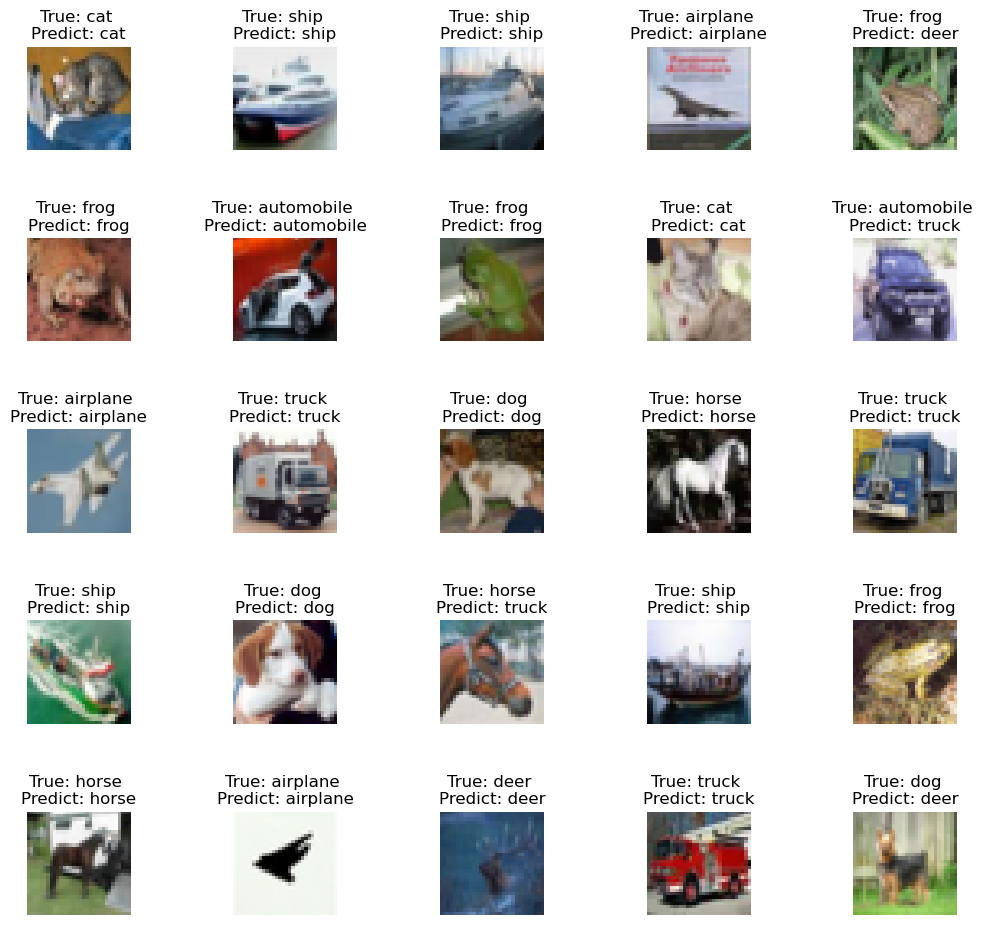

In [15]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(25):
    axes[i].imshow(x_test[i])
    axes[i].set_title('True: %s \nPredict: %s' % (classes[y_true[i]], classes[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

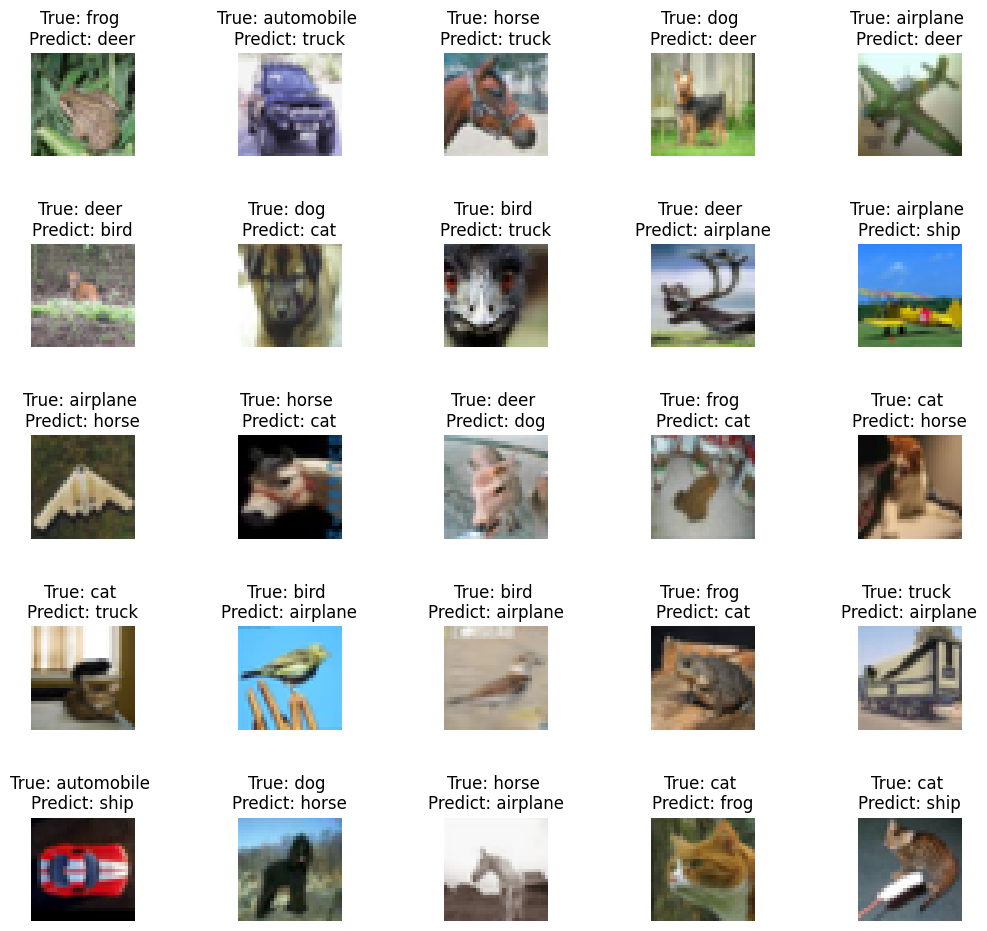

In [19]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

miss_pred = np.where(y_pred != y_true)[0]
for i in np.arange(25):
    axes[i].imshow(x_test[miss_pred[i]])
    axes[i].set_title('True: %s \nPredict: %s' % (classes[y_true[miss_pred[i]]], classes[y_pred[miss_pred[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

# Guardar o modelo

In [20]:
melhor_model.save('cifar10_CNN_DataAugmentation.keras')